## Super Mario Bros

In [1]:
import gym
import torch
from torch import optim
import torch.nn.functional as F
from torch.nn import MSELoss, CrossEntropyLoss
from torch.nn import Conv2d, Linear
from torch.optim import Adam
from random import shuffle
from torch import nn
from collections import deque
import matplotlib.pyplot as plt
from skimage.transform import resize
import numpy as np
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

In [3]:
env = gym_super_mario_bros.make("SuperMarioBros-v0")
env = JoypadSpace(env, COMPLEX_MOVEMENT)

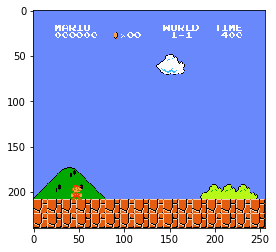

In [12]:
plt.imshow(env.render("rgb_array"));

In [3]:
finished = True

for step in range(2_500):
    if finished:
        state = env.reset()
    state, reward, finished, _ = env.step(env.action_space.sample())
    env.render()
    
env.close()

In [4]:
def downscale_state(state, new_size = (42, 42), to_gray = True):
    '''Resizes to (42, 42) and converts to grayscale'''
    if to_gray:
        return resize(state, new_size, anti_aliasing = True).max(axis = 2)
    else:
        return resize(state, new_size, anti_aliasing = True)

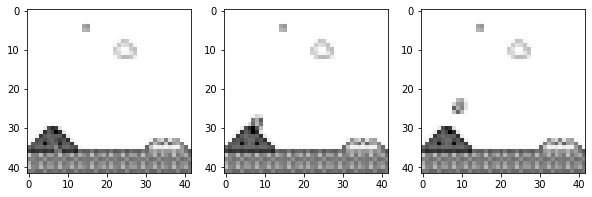

In [37]:
env.reset()

fig = plt.figure(figsize = (10, 15))
for i in range(30):
    if i % 10 == 0:
        plt.subplot(1, 3, i/10 + 1)
        plt.imshow(downscale_state(env.render("rgb_array")), cmap = 'gray')
    _, _, _, _ = env.step(2)

### Auxiliary functions

In [5]:
def prepare_state(state):
    '''Converts state to grayscale and adds batch dimension'''
    state = torch.from_numpy(downscale_state(state)).float()
    state = state.unsqueeze(dim = 0)
    return state

def prepare_state_seq(state_1, state_2):
    '''Adds state_2 to state_1 as a new frame in a sequence (queue) of state arrays'''
    state_1 = state_1.clone()
    state_2 = torch.from_numpy(downscale_state(state_2)).float()
    state_1[0, 0] = state_1[0, 1]
    state_1[0, 1] = state_1[0, 2]
    state_1[0, 2] = state_2
    return state_1

def prepare_initial_state(state, num_dims = 3):
    '''Creates a sequence of state arrays with the same state as the 3 frames'''
    state = torch.from_numpy(downscale_state(state)).float()
    state = state.repeat((num_dims, 1, 1))
    state = state.unsqueeze(dim = 0)
    return state

def reset_env():
    """Reset the environment and return a new initial state"""
    env.reset()
    state = prepare_initial_state(env.render('rgb_array'))
    return state

### Experience Replay and Policy Function

In [6]:
def policy_function(q_values, epsilon = None):
    '''Choose action by epsilon-greedy or multinomial sampling'''
    if epsilon is not None:
        if torch.rand(1) < epsilon:
            return torch.randint(0, 7, size = (1,))
        else:
            return torch.argmax(q_values)
    else:
        return torch.multinomial(F.softmax(F.normalize(q_values), dim = 1), num_samples = 1)
    
class ExperienceReplay:
    '''Experience replay class that contains a list of tuples with minibatch functionality'''
    def __init__(self, n = 1_000, batch_size = 100):
        self.n = n
        self.batch_size = batch_size
        self.memory = []
        self.counter = 0
        
    def add_memory(self, state, action, reward, state_new):
        self.counter +=1
        if self.counter % 500 == 0:
            self.shuffle_memory()
            
        if len(self.memory) < self.n:
            self.memory.append((state, action, reward, state_new))
        else:
            i_random = np.random.randint(0, self.n - 1)
            self.memory[i_random] = (state, action, reward, state_new)
    
    def shuffle_memory(self):
        shuffle(self.memory)
        
    def get_batch(self):
        if len(self.memory) < self.batch_size:
            batch_size = len(self.memory)
        else:
            batch_size = self.batch_size
        if len(self.memory) < 1:
            print("Error: No data in memory.")
            return None
        
        indices = np.random.choice(np.arange(len(self.memory)), batch_size, replace = False)
        batch = [self.memory[i] for i in indices]
        states_b = torch.stack([s.squeeze(dim = 0) for (s, a, r, s_n) in batch], dim = 0)
        actions_b = torch.Tensor([a for (s, a, r, s_n) in batch]).long()
        rewards_b = torch.Tensor([r for (s, a, r, s_n) in batch])
        states_new_b = torch.stack([s_n.squeeze(dim = 0) for (s, a, r, s_n) in batch], dim = 0)
        return states_b, actions_b, rewards_b, states_new_b

### Intrinsic Curiosity Module

In [7]:
class EncoderNetwork(nn.Module):
    '''
    Transforms three-frame states into a low-dimensional vector.
    Encodes states for InverseModel and ForwardModel.
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(3, 32, (3, 3), stride = 2, padding = 1)
        self.conv2 = Conv2d(32, 32, (3, 3), stride = 2, padding = 1)
        self.conv3 = Conv2d(32, 32, (3, 3), stride = 2, padding = 1)
        self.conv4 = Conv2d(32, 32, (3, 3), stride = 2, padding = 1)
        
    def forward(self, x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y))
        y = y.flatten(start_dim = 1) 
        return y # (n, 288)
    
class InverseModel(nn.Module):
    '''
    Predicts the action that was taken, given two successive encoded states.
    Trains the Encoder.
    '''
    def __init__(self):
        super().__init__()
        self.linear1 = Linear(288+288, 256)
        self.linear2 = Linear(256, 12)

    def forward(self, state, state_new):
        x = torch.cat((state, state_new), dim = 1)
        y = F.relu(self.linear1(x))
        y = self.linear2(y)
        y = F.softmax(y, dim = 1)
        return y # (n, 12)
    
class ForwardModel(nn.Module):
    '''
    Predicts the next encoded state, given action and current encoded state.
    Produces a prediction error (reward signal) for the QNetwork.
    '''
    def __init__(self):
        super().__init__()
        self.linear1 = Linear(300, 256)
        self.linear2 = Linear(256, 288)  

    def forward(self, state, action):
        action_ = torch.zeros(action.shape[0], 12)
        indices = torch.stack((torch.arange(action.shape[0]), action.squeeze()), dim = 0)
        indices = indices.tolist()
        action_[indices] = 1.0
        x = torch.cat((state, action_), dim = 1)
        y = F.relu(self.linear1(x))
        y = self.linear2(y)
        return y # (n, 288)
    
class QNetwork(nn.Module):
    '''
    2D-CNN that takes the (error of the ForwardModel + actual reward) as reward.
    The QNetwork and Curiosity Module contribute to the overall loss being optimized.
    Outputs Q-value predictions.
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(3, 32, (3, 3), stride = 2, padding = 1)
        self.conv2 = Conv2d(32, 32, (3, 3), stride = 2, padding = 1)
        self.conv3 = Conv2d(32, 32, (3, 3), stride = 2, padding = 1)
        self.conv4 = Conv2d(32, 32, (3, 3), stride = 2, padding = 1)
        self.linear1 = Linear(288, 100)
        self.linear2 = Linear(100, 12)

    def forward(self, x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y))
        y = y.flatten(start_dim = 2)
        y = y.view(y.shape[0], -1, 32)
        y = y.flatten(start_dim = 1)
        y = F.elu(self.linear1(y))
        y = self.linear2(y)
        return y

### Model initiation

In [8]:
hyperparams = {
    'batch_size': 150,
    'beta': 0.2,
    'lambda': 0.1,
    'eta': 1.0,
    'discount': 0.2,
    'max_episode_len': 100,
    'min_progress': 15,
    'action_repeats': 6,
    'frames_per_state': 3
}

replay = ExperienceReplay(batch_size = hyperparams['batch_size'])

q_network = QNetwork()
encoder = EncoderNetwork()
forward_model = ForwardModel()
inverse_model = InverseModel()

q_network_loss = MSELoss()
forward_loss = MSELoss(reduction = 'none')
inverse_loss = CrossEntropyLoss(reduction = 'none')

model_params = list(q_network.parameters()) + list(encoder.parameters()) + \
               list(forward_model.parameters()) + list(inverse_model.parameters())

optimizer = Adam(model_params, lr = 1e-3)

### Loss Function

In [9]:
def loss_function(q_loss, inverse_loss, forward_loss):
    loss_ = (1 - hyperparams['beta']) * inverse_loss + hyperparams['beta'] * forward_loss
    loss_ = loss_.sum() / loss_.flatten().shape[0]
    loss = loss_ + hyperparams['lambda'] * q_loss
    return loss

def icm_pred_error(state, action, state_new, forward_scale = 1.0, inverse_scale = 1e4):
    state_enc = encoder(state)
    state_new_enc = encoder(state_new)
    state_new_enc_pred = forward_model(state_enc.detach(), action.detach())
    forward_pred_err = forward_scale * forward_loss(state_new_enc_pred, \
                       state_new_enc.detach()).sum(dim = 1).unsqueeze(dim = 1)
    action_pred = inverse_model(state_enc, state_new_enc)
    inverse_pred_err = inverse_scale * inverse_loss(action_pred, \
                       action.detach().flatten()).unsqueeze(dim = 1)
    return forward_pred_err, inverse_pred_err

### Training

In [10]:
def minibatch_train(use_extrinsic = True):
    state_b, action_b, reward_b, state_new_b = replay.get_batch()
    action_b = action_b.view(action_b.shape[0], 1)
    reward_b = reward_b.view(reward_b.shape[0], 1)
    forward_pred_err, inverse_pred_err = icm_pred_error(state_b, action_b, state_new_b)
    i_reward = (1.0 / hyperparams['eta']) * forward_pred_err
    reward = i_reward.detach()
    if use_explicit:
        reward += reward_b
    q_vals = q_network(state_new_b)
    reward += hyperparams['discount'] * torch.max(q_vals)
    reward_pred = q_network(state_b)
    reward_target = reward_pred.clone()
    indices = torch.stack((torch.arange(action_b.shape[0]), action_b.squeeze()), dim = 0)
    indices = indices.tolist()
    reward_target[indices] = reward.squeeze()
    q_loss = 1e5 * q_network_loss(F.normalize(reward_pred), F.normalize(reward_target.detach()))
    return forward_pred_err, inverse_pred_err, q_loss

In [11]:
env.reset()

num_epochs = 3_500
state = prepare_initial_state(env.render('rgb_array'))
epsilon = 0.15
losses = []
actions_taken = 0
episode_lens = []
switch_to_eps_greedy = 1_000
state_deque = deque(maxlen = hyperparams['frames_per_state'])
exp_reward = 0.0
last_x_pos = env.env.env._x_position
use_explicit = False

for i_epoch in range(num_epochs):
    optimizer.zero_grad()
    actions_taken += 1
    q_val_pred = q_network(state)
    # Switch to epsilon-greedy
    if i_epoch > switch_to_eps_greedy:
        action = int(policy_function(q_val_pred, epsilon))
    else:
        action = int(policy_function(q_val_pred))
    # Repeat chosen action to speed up learning
    for i_repeat in range(hyperparams['action_repeats']):
        state_new, exp_reward_, finished, info = env.step(action)
        last_x_pos = info['x_pos']
        if finished:
            state = reset_env()
            break
        exp_reward += exp_reward_
        state_deque.append(prepare_state(state_new))
    state_new = torch.stack(list(state_deque), dim = 1)
    replay.add_memory(state, action, exp_reward, state_new)
    exp_reward = 0
    # Restart game if progress isn't made
    if actions_taken > hyperparams['max_episode_len']:
        if (info['x_pos'] - last_x_pos) < hyperparams['min_progress']:
            finished = True
        else:
            last_x_pos = info['x_pos']
    # Check if episode is finished
    if finished:
        episode_lens.append(info['x_pos'])
        state = reset_env()
        last_x_pos = env.env.env._x_position
        actions_taken = 0
    else:
        state = state_new
    if len(replay.memory) < hyperparams['batch_size']:
        continue
    # Compute loss and update parameters
    forward_pred_err, inverse_pred_err, q_loss = minibatch_train(use_extrinsic = False)
    loss = loss_function(q_loss, forward_pred_err, inverse_pred_err)
    losses.append((
        q_loss.detach().numpy().mean(),
        forward_pred_err.flatten().detach().numpy().mean(),
        inverse_pred_err.flatten().detach().numpy().mean()
    ))
    loss.backward()
    optimizer.step()
    # Print progress
    if i_epoch % 300 == 0:
        print(f'''
        Epoch: {i_epoch:04d}
        Forward loss: {np.mean([l2 for (l1, l2, l3) in losses][-300:]):.2f}
        Inverse loss: {np.mean([l3 for (l1, l2, l3) in losses][-300:]):.2f}
        Q-Network loss: {np.mean([l1 for (l1, l2, l3) in losses][-300:]):.2f}
        ''')


        Epoch: 0300
        Forward loss: 4.30
        Inverse loss: 24413.86
        Q-Network loss: 2102.63
        

        Epoch: 0600
        Forward loss: 0.66
        Inverse loss: 24693.93
        Q-Network loss: 251.81
        

        Epoch: 0900
        Forward loss: 0.11
        Inverse loss: 24808.57
        Q-Network loss: 322.56
        

        Epoch: 1200
        Forward loss: 0.08
        Inverse loss: 24842.80
        Q-Network loss: 361.40
        

        Epoch: 1500
        Forward loss: 0.98
        Inverse loss: 24848.08
        Q-Network loss: 260.06
        

        Epoch: 1800
        Forward loss: 0.36
        Inverse loss: 24846.06
        Q-Network loss: 348.91
        

        Epoch: 2100
        Forward loss: 0.20
        Inverse loss: 24843.78
        Q-Network loss: 373.97
        

        Epoch: 2400
        Forward loss: 0.16
        Inverse loss: 24848.49
        Q-Network loss: 385.33
        

        Epoch: 2700
        Forward loss: 0.15

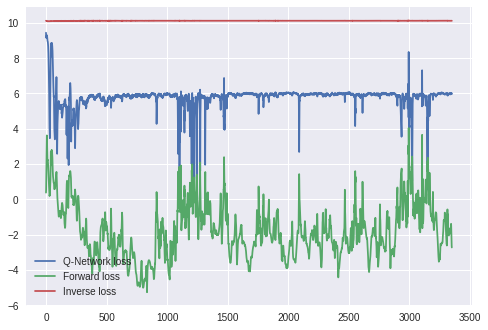

In [24]:
losses = np.log(np.array(losses))

plt.plot(losses[:, 0], label = 'Q-Network loss')
plt.plot(losses[:, 1], label = 'Forward loss')
plt.plot(losses[:, 2], label = 'Inverse loss')
plt.legend(loc = 'lower left')
plt.show()

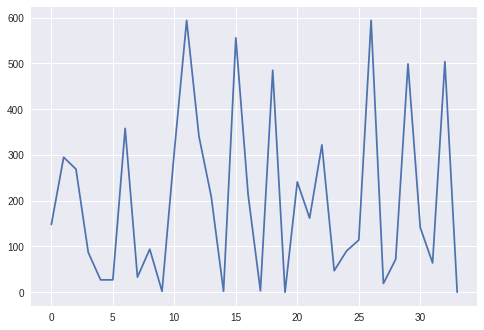

In [21]:
plt.plot(episode_lens);

In [ ]:
epsilon = 0.1
finished = True
state_deque = deque(maxlen = hyperparams['frames_per_state'])

for i in range(5_000):
    if finished:
        env.reset()
        state = prepare_initial_state(env.render('rgb_array'))
    q_val_pred = q_network(state)
    action = int(policy_function(q_val_pred, epsilon))
    state_new, _, finished, _ = env.step(action)
    state_new = prepare_state_seq(state, state_new)
    state = state_new
    env.render()
    
env.close()